In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

train_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [3]:
print(train_data.info())
print(test_data.info())

missing_train = (train_data.isnull().sum() / len(train_data)) * 100
missing_test = (test_data.isnull().sum() / len(test_data)) * 100

print("Missing values in train data:\n", missing_train[missing_train > 0].sort_values(ascending=False))
print("Missing values in test data:\n", missing_test[missing_test > 0].sort_values(ascending=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Data cleaning

#### To know
1. select_dtypes : 특정 타입의 데이터를 추려줌
2. SimpleImputer : Nan 값을 채움(mean(평균), median(중앙값), most_frequent(최빈값), constant(지정값)

In [4]:
drop_cols = ['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType','FireplaceQu', 'LotFrontage']
X_train = train_data.drop(columns=drop_cols + ['SalePrice'])
y_train = train_data['SalePrice']
X_test = test_data.drop(columns=drop_cols)

numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

X_train[numerical_cols] = numerical_imputer.fit_transform(X_train[numerical_cols])
X_train[categorical_cols] = categorical_imputer.fit_transform(X_train[categorical_cols])
X_test[numerical_cols] = numerical_imputer.fit_transform(X_test[numerical_cols])
X_test[categorical_cols] = categorical_imputer.fit_transform(X_test[categorical_cols])

## Features Extraction

In [5]:
X_train['AgeOfHouse'] = X_train['YrSold'] - X_train['YearBuilt']
X_test['AgeOfHouse'] = X_test['YrSold'] - X_test['YearBuilt']

X_train['TotalBsmtArea'] = X_train['BsmtFinSF1'] + X_train['BsmtFinSF2'] + X_train['BsmtUnfSF']
X_test['TotalBsmtArea'] = X_test['BsmtFinSF1'] + X_test['BsmtFinSF2'] + X_test['BsmtUnfSF']

X_train['RoomsPerSqft'] = X_train['TotRmsAbvGrd'] / X_train['GrLivArea']
X_test['RoomsPerSqft'] = X_test['TotRmsAbvGrd'] / X_test['GrLivArea']

## Data Visualization

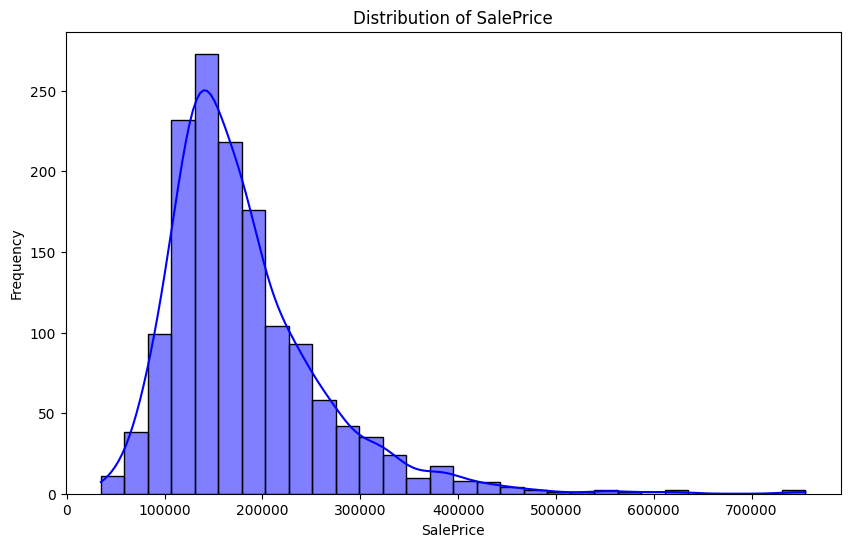

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['SalePrice'], kde=True, bins=30, color='blue')
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

집들의 가격 분포도

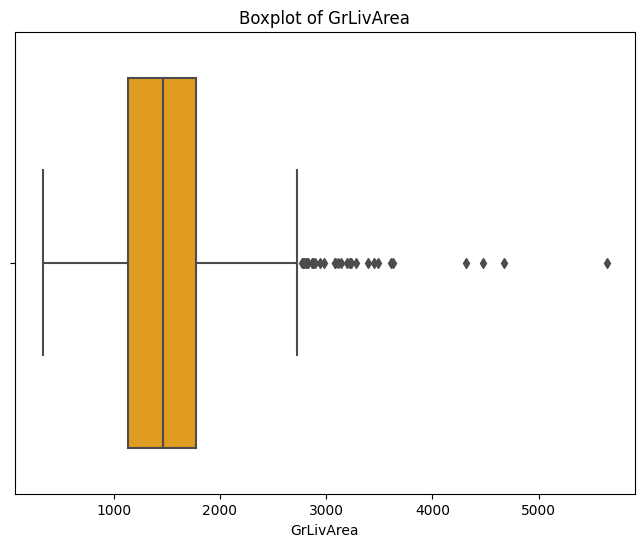

In [7]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=train_data['GrLivArea'], color='orange')
plt.title("Boxplot of GrLivArea")
plt.xlabel("GrLivArea")
plt.show()

GrLivArea 칼럼의 데이터 분포와 이상치 유무를 판단
약 300에서 약 2800까지 데이터가 분포해 있으며 1000에서 2000 사이에 대부분의 데이터가 집중 부높되어 있다 하지만 약 3000을 넘는 이상치가 몇몇 존재한다

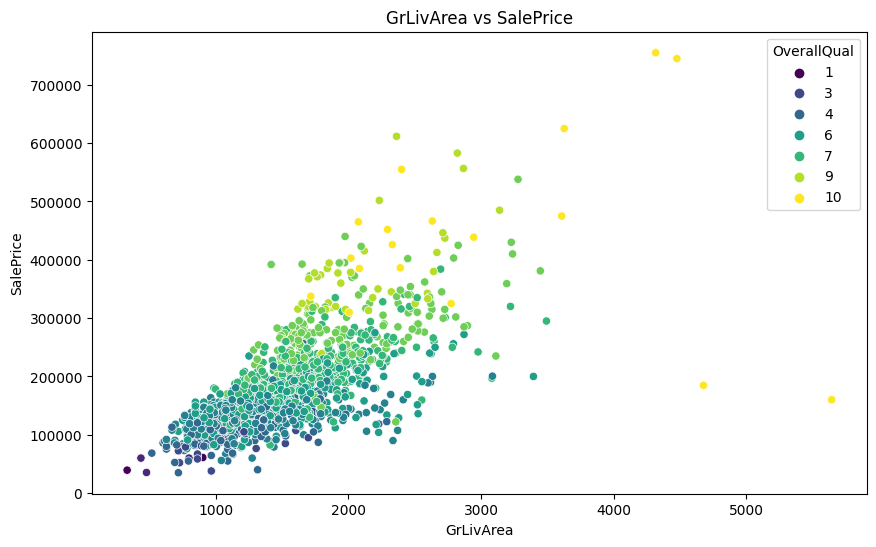

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_data['GrLivArea'], y=train_data['SalePrice'], hue=train_data['OverallQual'], palette="viridis")
plt.title("GrLivArea vs SalePrice")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

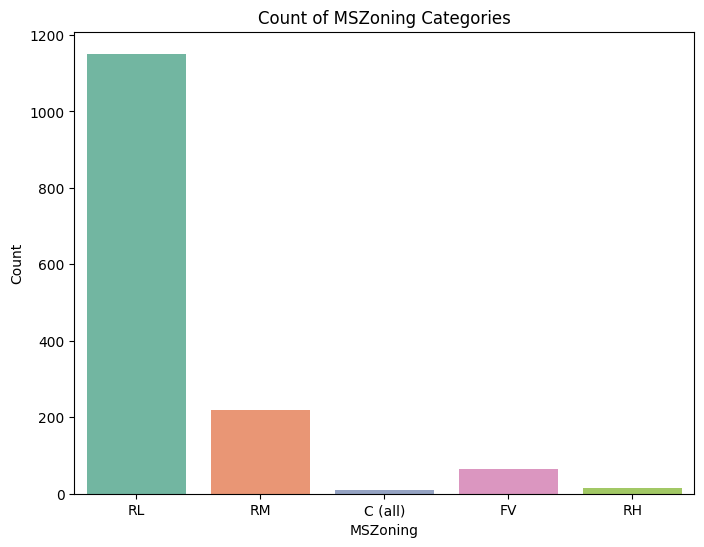

In [9]:
plt.figure(figsize=(8, 6))
sns.countplot(x="MSZoning", data=train_data, palette='Set2')
plt.title("Count of MSZoning Categories")
plt.xlabel('MSZoning')
plt.ylabel("Count")
plt.show()

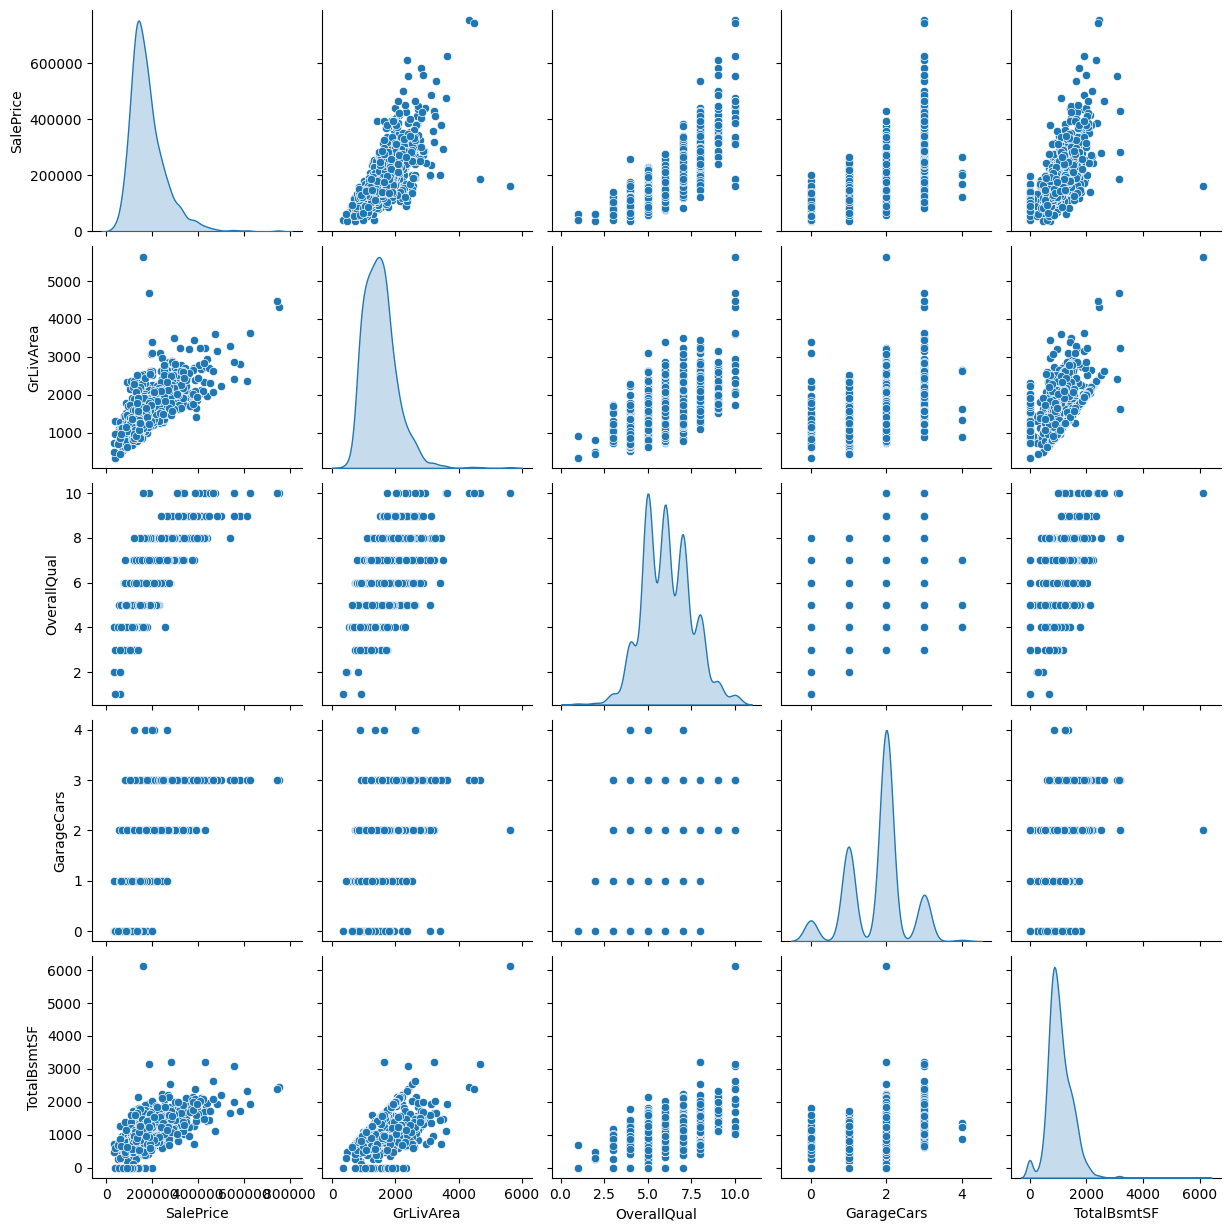

In [10]:
selected_columns = ['SalePrice', 'GrLivArea', 'OverallQual', 'GarageCars', 'TotalBsmtSF']
sns.pairplot(train_data[selected_columns], diag_kind="kde", kind="scatter", palette="husl")
plt.show()

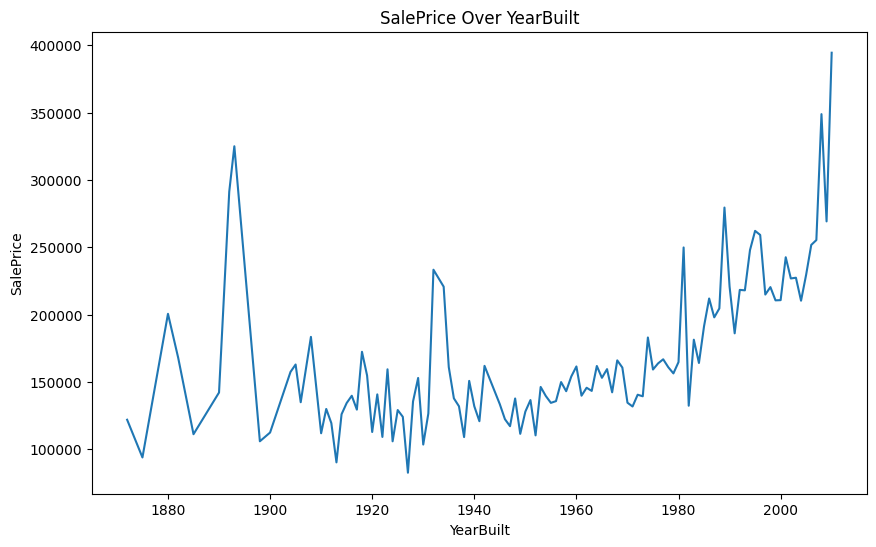

In [11]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='YearBuilt', y='SalePrice', data=train_data, ci=None)
plt.title("SalePrice Over YearBuilt")
plt.xlabel("YearBuilt")
plt.ylabel("SalePrice")
plt.show()

lineplot은 x축에 해당하는 데이터들의 결과의 평균값임 즉 특정 년도에 지어진 건물들의 평균 가격의 값들이라고 이해하면 됨

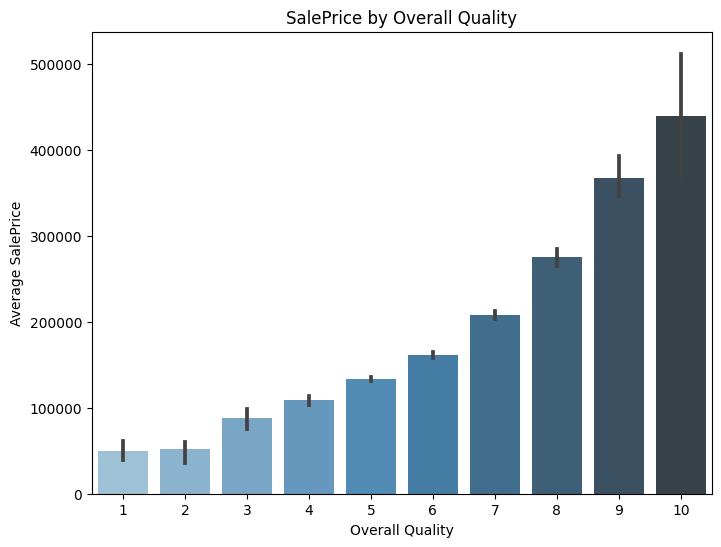

In [12]:
plt.figure(figsize=(8, 6))
sns.barplot(x='OverallQual', y='SalePrice', data=train_data, palette='Blues_d')
plt.title("SalePrice by Overall Quality")
plt.xlabel("Overall Quality")
plt.ylabel("Average SalePrice")
plt.show()

lineplot과 마찬가지로 평균값을 나타냄
각 막대의 위에 위치한 검은 선은 95%의 신뢰구간임
이 막대를 통해 데이터가 평균값 주변에 어느정도 퍼져있는지, 이 막대가 가리키는 데이터의 평균값을 얼마나 신뢰할 수 있는지를 알 수 있음

In [13]:
categorical_cols

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')

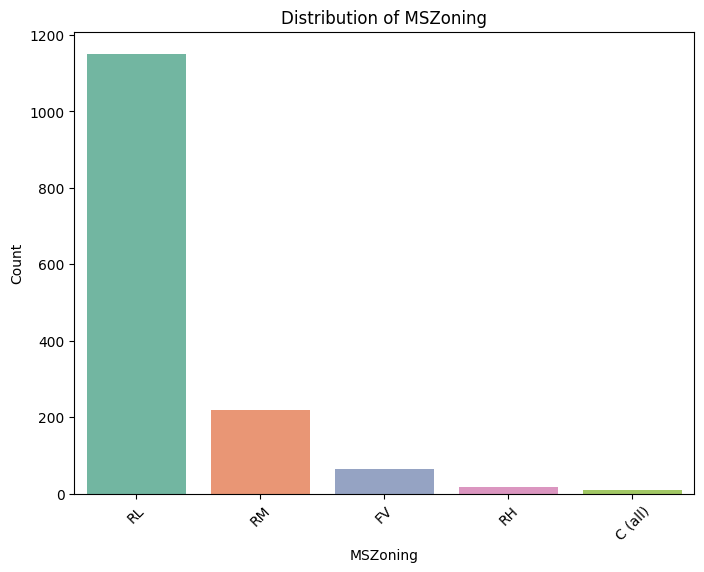

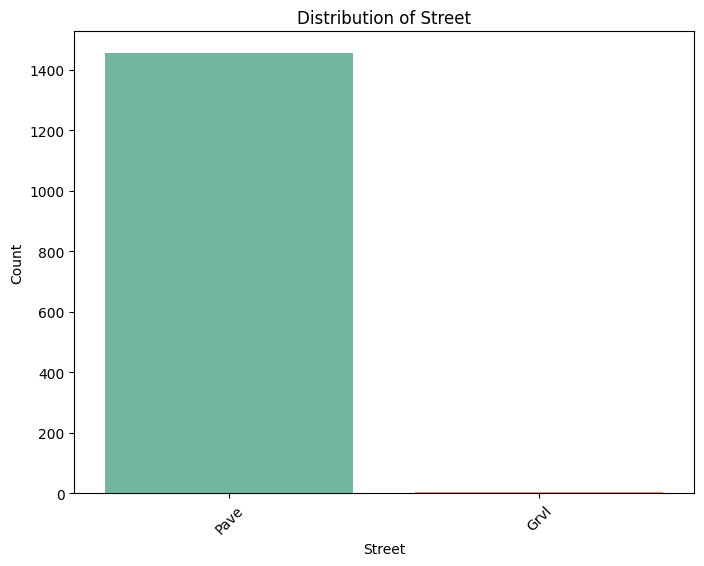

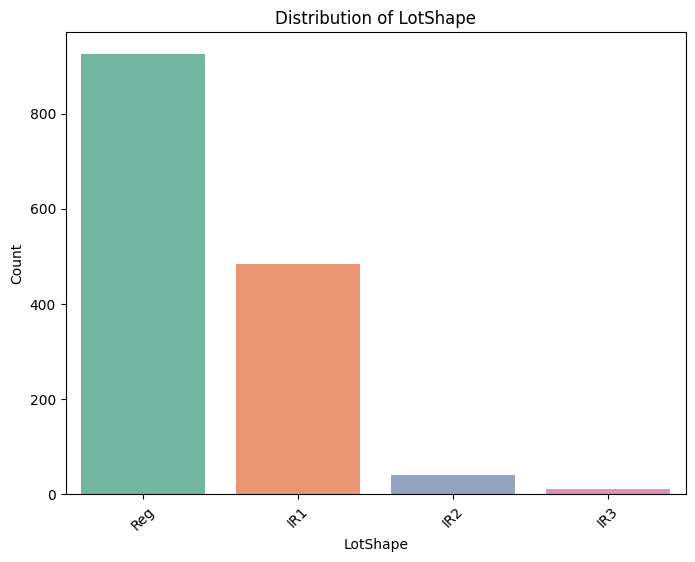

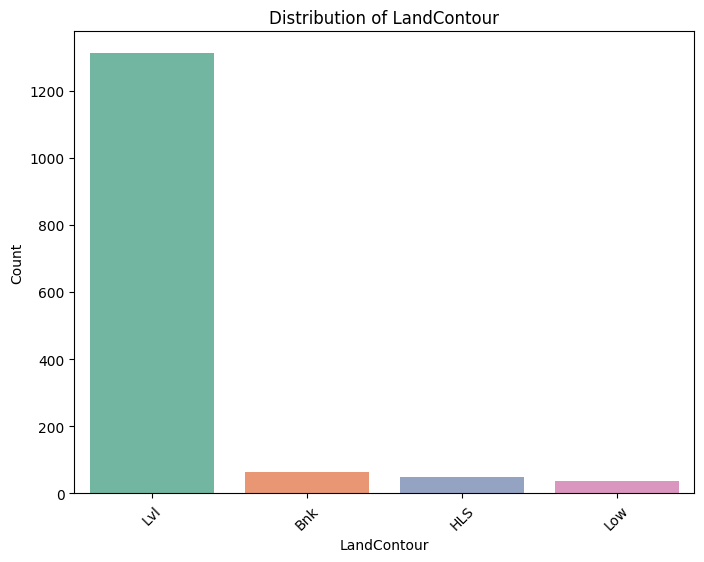

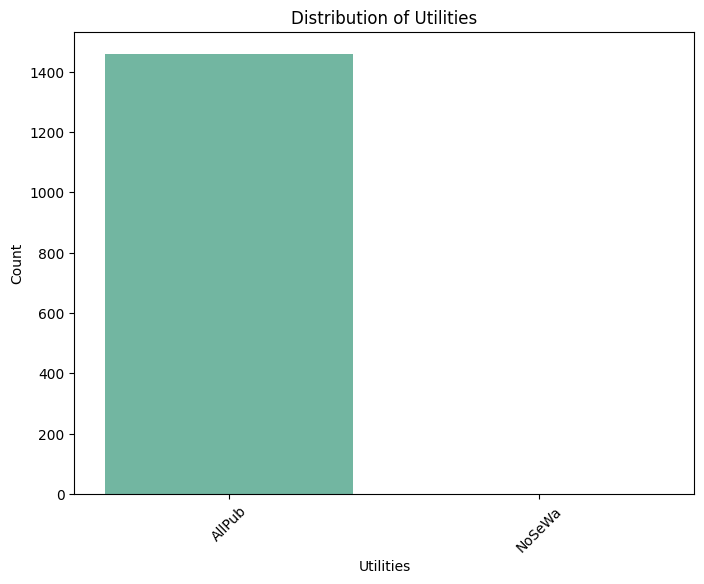

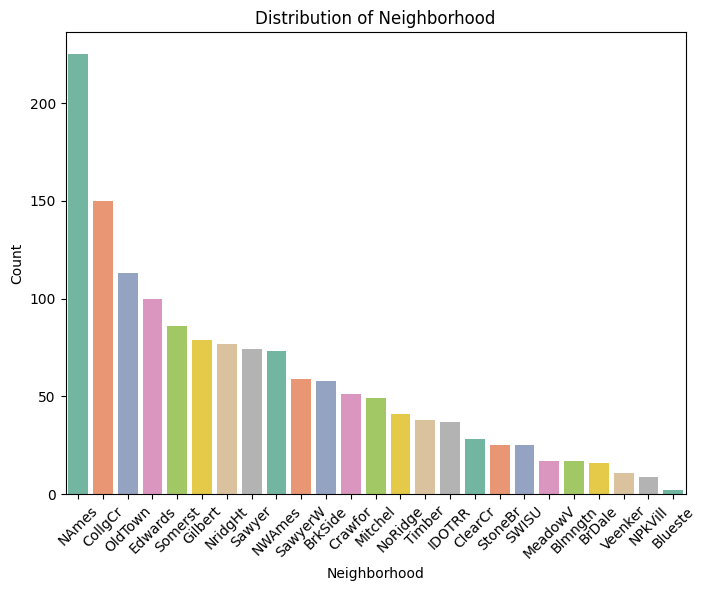

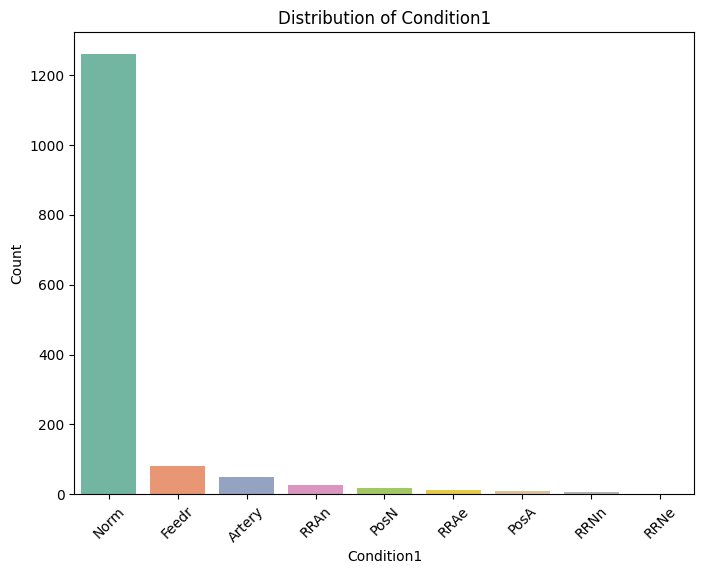

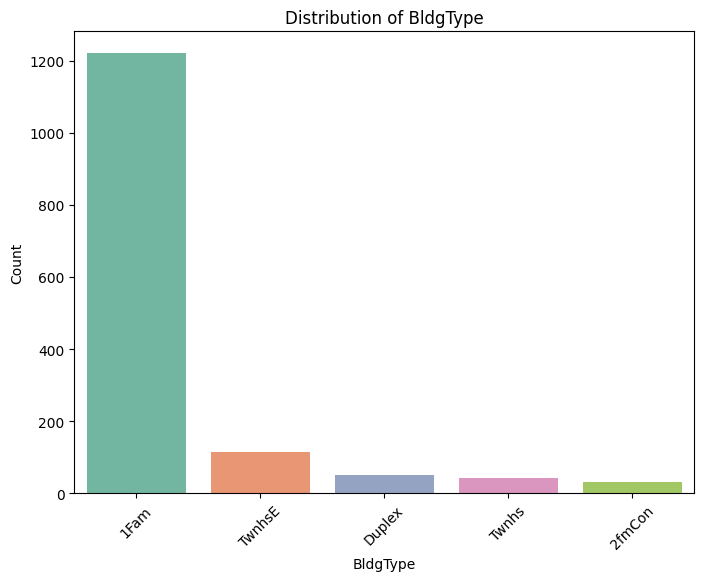

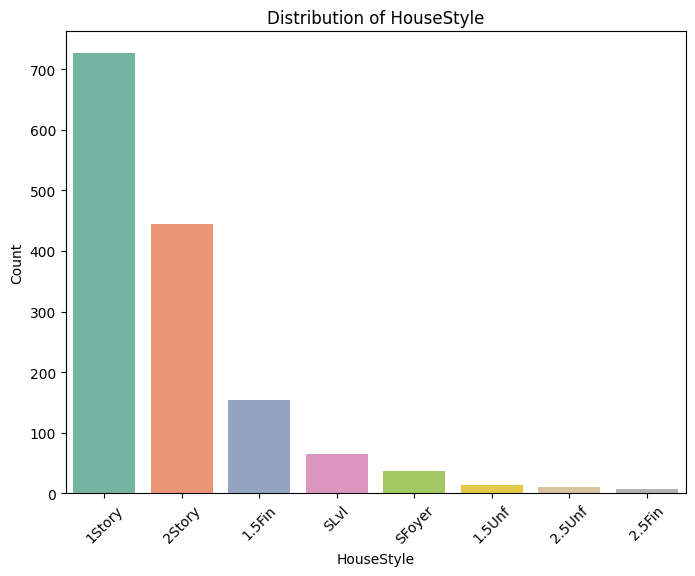

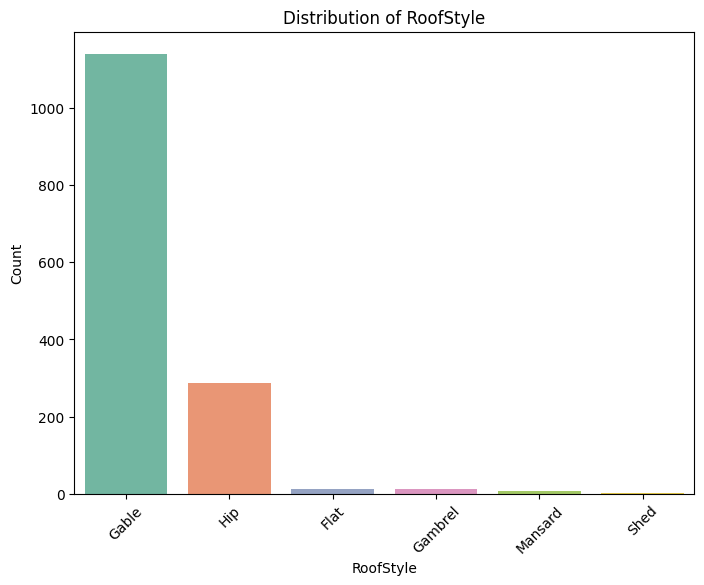

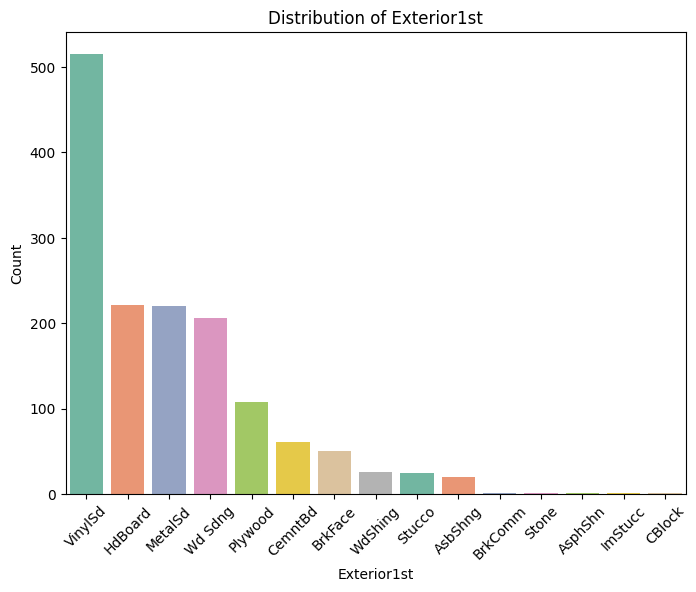

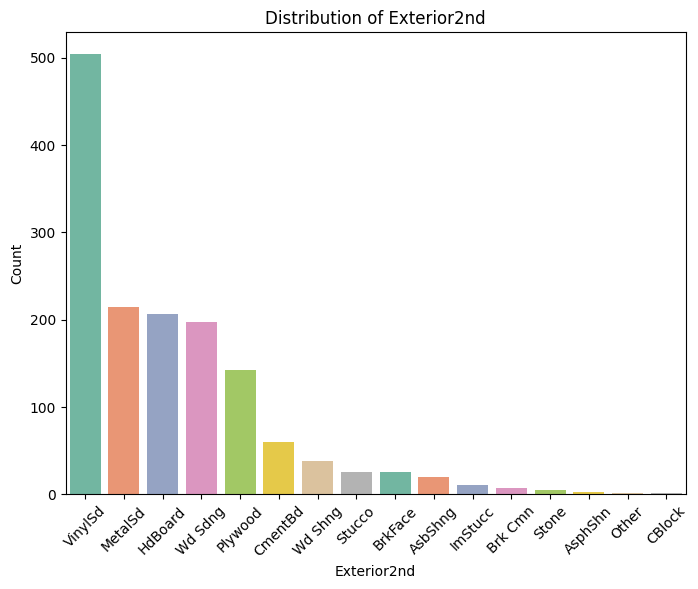

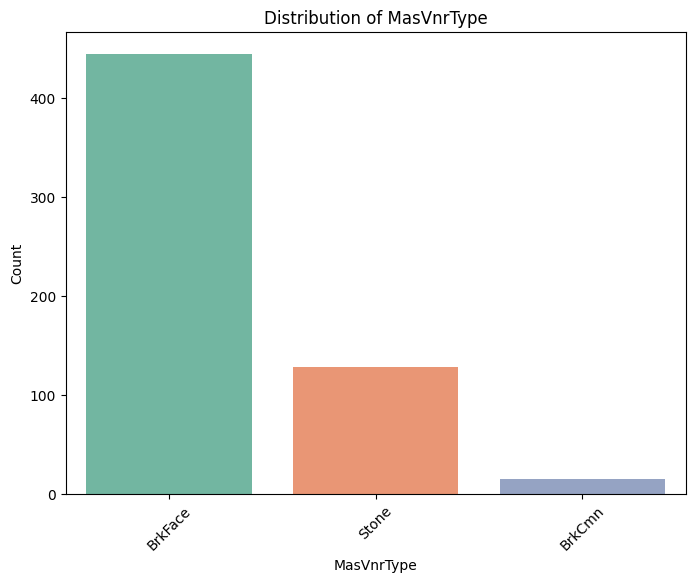

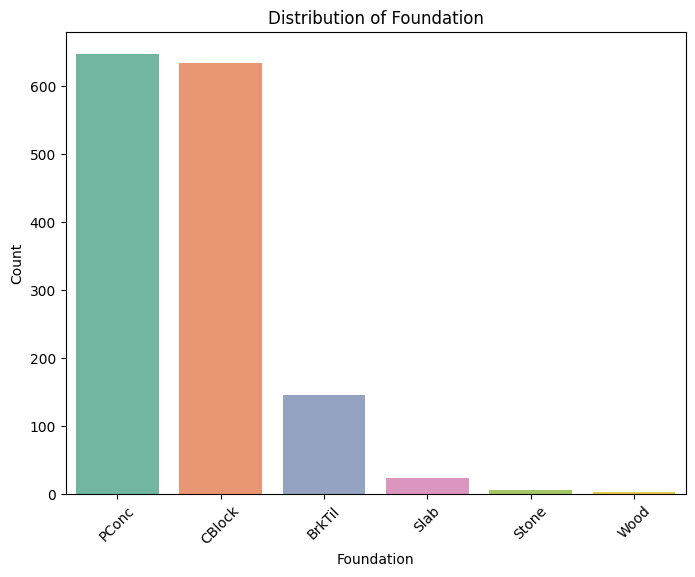

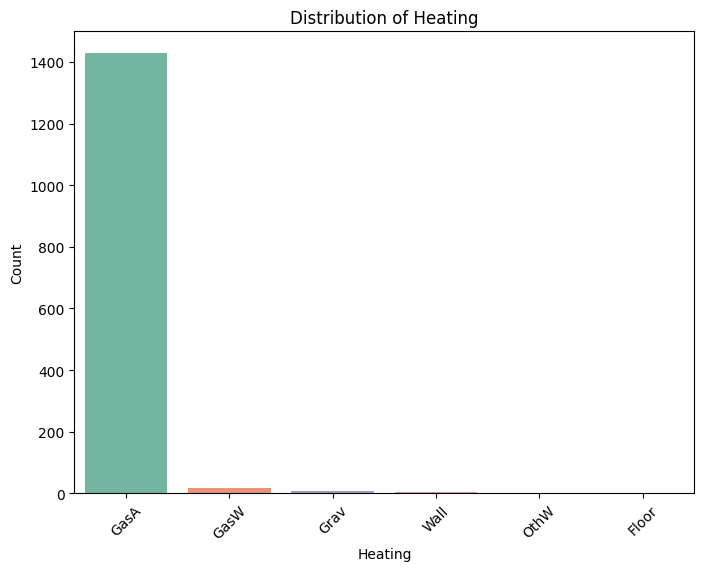

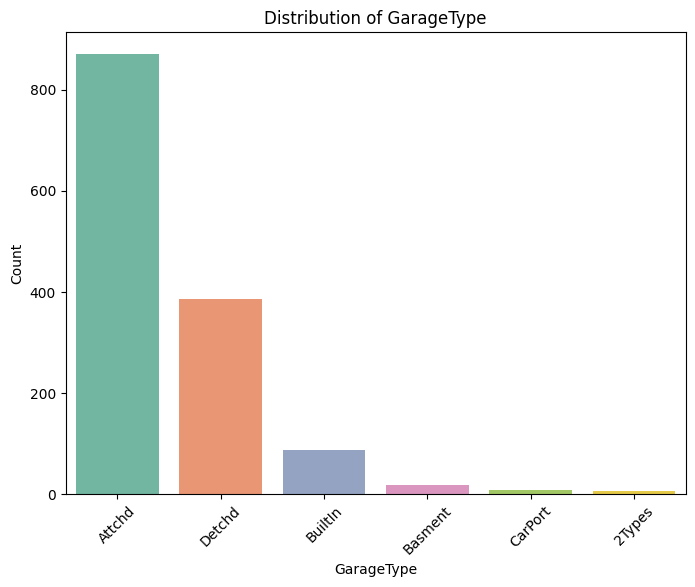

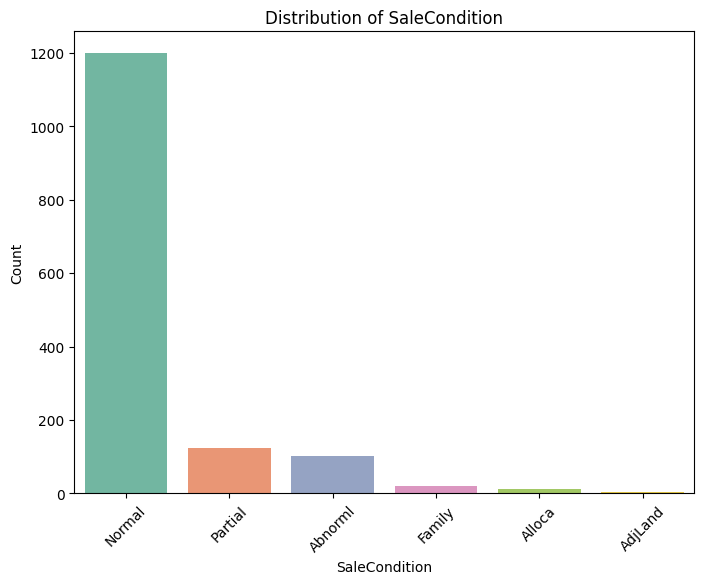

In [14]:
categorical_columns = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 
                       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 
                       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
                       'Foundation', 'Heating', 'GarageType', 'SaleCondition']

# Loop through categorical columns and visualize the distribution
for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    if col in train_data.columns:  
        sns.countplot(x=train_data[col], order=train_data[col].value_counts().index, palette="Set2")
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.show()
    else:
        print(f"Column {col} is not in the DataFrame.")

In [15]:
X_train, X_test

(      MSSubClass MSZoning  LotArea Street LotShape LandContour Utilities  \
 0           60.0       RL   8450.0   Pave      Reg         Lvl    AllPub   
 1           20.0       RL   9600.0   Pave      Reg         Lvl    AllPub   
 2           60.0       RL  11250.0   Pave      IR1         Lvl    AllPub   
 3           70.0       RL   9550.0   Pave      IR1         Lvl    AllPub   
 4           60.0       RL  14260.0   Pave      IR1         Lvl    AllPub   
 ...          ...      ...      ...    ...      ...         ...       ...   
 1455        60.0       RL   7917.0   Pave      Reg         Lvl    AllPub   
 1456        20.0       RL  13175.0   Pave      Reg         Lvl    AllPub   
 1457        70.0       RL   9042.0   Pave      Reg         Lvl    AllPub   
 1458        20.0       RL   9717.0   Pave      Reg         Lvl    AllPub   
 1459        20.0       RL   9937.0   Pave      Reg         Lvl    AllPub   
 
      LotConfig LandSlope Neighborhood  ... ScreenPorch PoolArea MiscVal  

## Encoding

In [16]:
# Encoding Categorical Variables
label_encoders = {}
for column in categorical_cols:
    le = LabelEncoder()
    X_train[column] = le.fit_transform(X_train[column])
    X_test[column] = le.transform(X_test[column])
    label_encoders[column] = le

train 데이터에 label encoder를 맞추고 test데이터에는 적용만 함

In [17]:
# Example: Reverse mapping for a single column
column = 'Utilities'  # Replace with a column name from your categorical_cols

for column in categorical_cols:
    le = label_encoders[column]  # Get the LabelEncoder for the column
    
    # Get unique encoded values
    unique_encoded_values = X_train[column].unique()
    
    # Decode them back to original categories
    decoded_values = le.inverse_transform(unique_encoded_values)
    
    # Print the mappings
    print(f"Column: {column}")
    print("Encoded -> Original:")
    for encoded, original in zip(unique_encoded_values, decoded_values):
        print(f"{encoded} -> {original}")
    print("-" * 30)

Column: MSZoning
Encoded -> Original:
3 -> RL
4 -> RM
0 -> C (all)
1 -> FV
2 -> RH
------------------------------
Column: Street
Encoded -> Original:
1 -> Pave
0 -> Grvl
------------------------------
Column: LotShape
Encoded -> Original:
3 -> Reg
0 -> IR1
1 -> IR2
2 -> IR3
------------------------------
Column: LandContour
Encoded -> Original:
3 -> Lvl
0 -> Bnk
2 -> Low
1 -> HLS
------------------------------
Column: Utilities
Encoded -> Original:
0 -> AllPub
1 -> NoSeWa
------------------------------
Column: LotConfig
Encoded -> Original:
4 -> Inside
2 -> FR2
0 -> Corner
1 -> CulDSac
3 -> FR3
------------------------------
Column: LandSlope
Encoded -> Original:
0 -> Gtl
1 -> Mod
2 -> Sev
------------------------------
Column: Neighborhood
Encoded -> Original:
5 -> CollgCr
24 -> Veenker
6 -> Crawfor
15 -> NoRidge
11 -> Mitchel
21 -> Somerst
14 -> NWAmes
17 -> OldTown
3 -> BrkSide
19 -> Sawyer
16 -> NridgHt
12 -> NAmes
20 -> SawyerW
9 -> IDOTRR
10 -> MeadowV
7 -> Edwards
23 -> Timber
8

In [18]:
target_variable='SalePrice'

X_train_with_target = X_train.copy()
X_train_with_target['SalePrice'] = y_train

Checking ordinal relationship for column: MSZoning
MSZoning
0     74528.000000
1    214014.061538
2    131558.375000
3    191004.994787
4    126316.830275
Name: SalePrice, dtype: float64


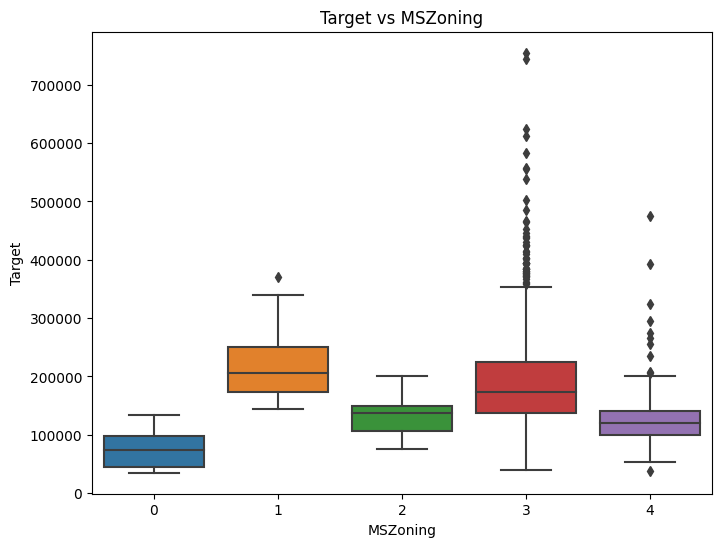

Checking ordinal relationship for column: Street
Street
0    130190.500000
1    181130.538514
Name: SalePrice, dtype: float64


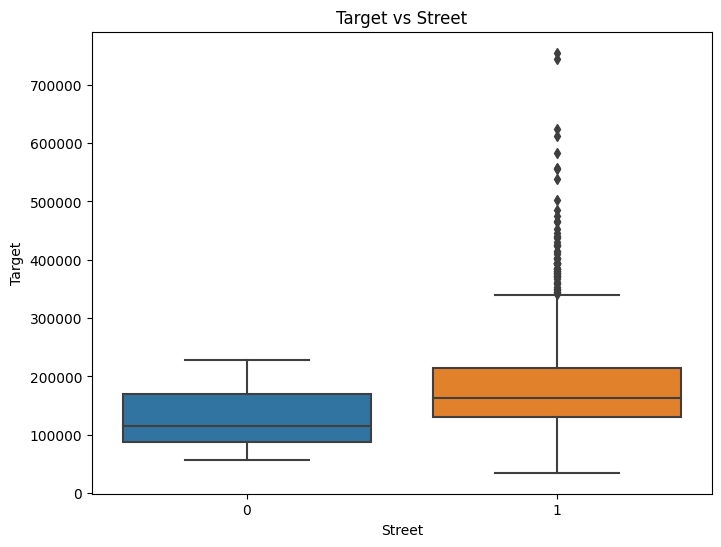

Checking ordinal relationship for column: LotShape
LotShape
0    206101.665289
1    239833.365854
2    216036.500000
3    164754.818378
Name: SalePrice, dtype: float64


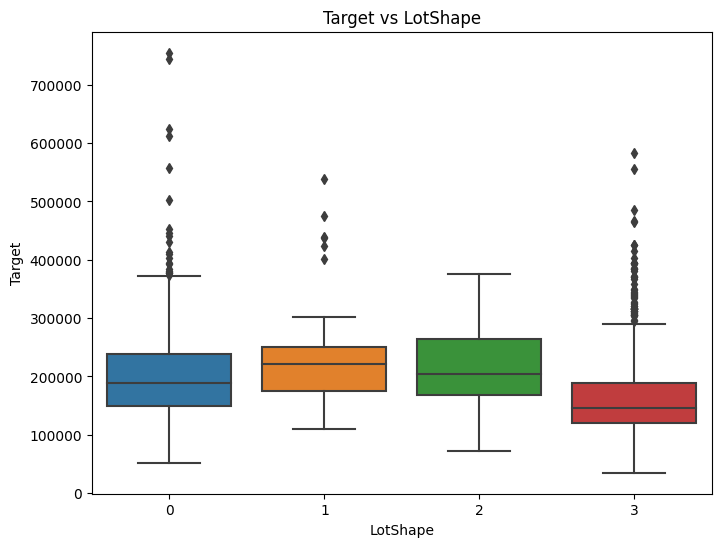

Checking ordinal relationship for column: LandContour
LandContour
0    143104.079365
1    231533.940000
2    203661.111111
3    180183.746758
Name: SalePrice, dtype: float64


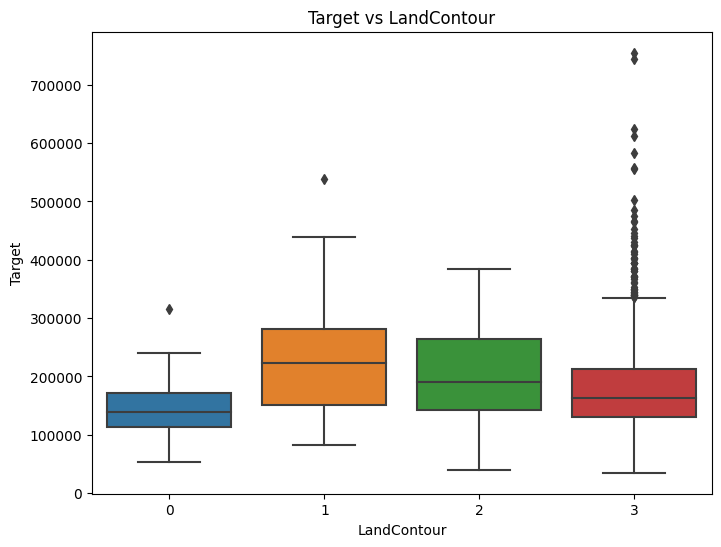

Checking ordinal relationship for column: Utilities
Utilities
0    180950.95682
1    137500.00000
Name: SalePrice, dtype: float64


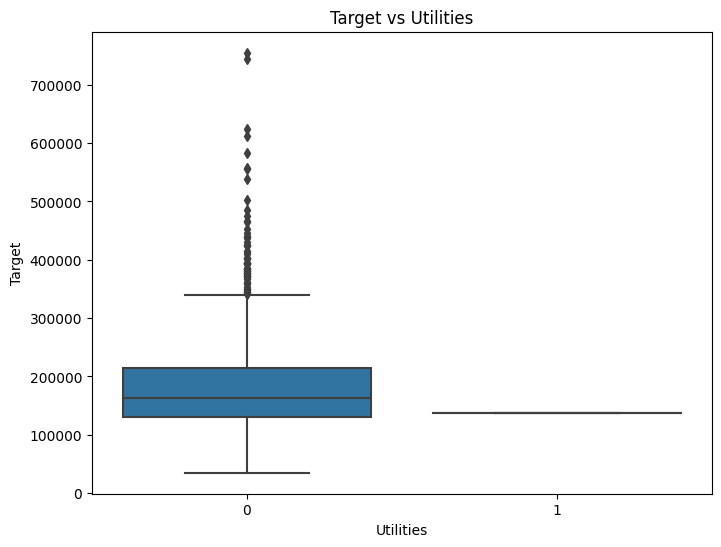

Checking ordinal relationship for column: LotConfig
LotConfig
0    181623.425856
1    223854.617021
2    177934.574468
3    208475.000000
4    176938.047529
Name: SalePrice, dtype: float64


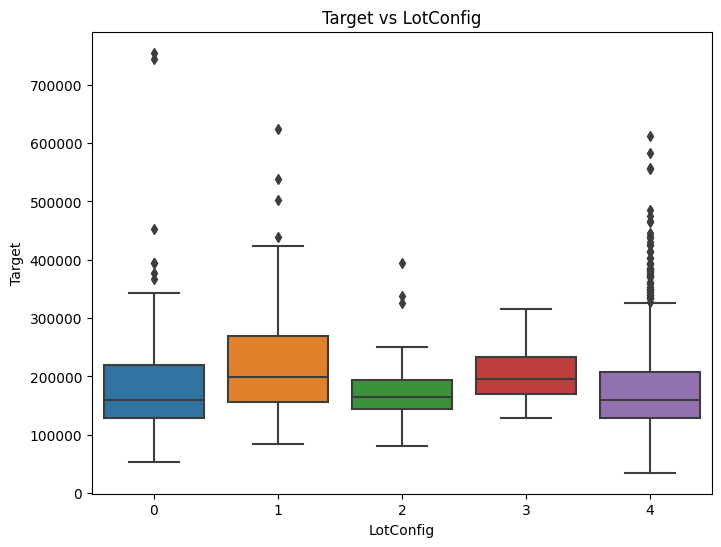

Checking ordinal relationship for column: LandSlope
LandSlope
0    179956.799566
1    196734.138462
2    204379.230769
Name: SalePrice, dtype: float64


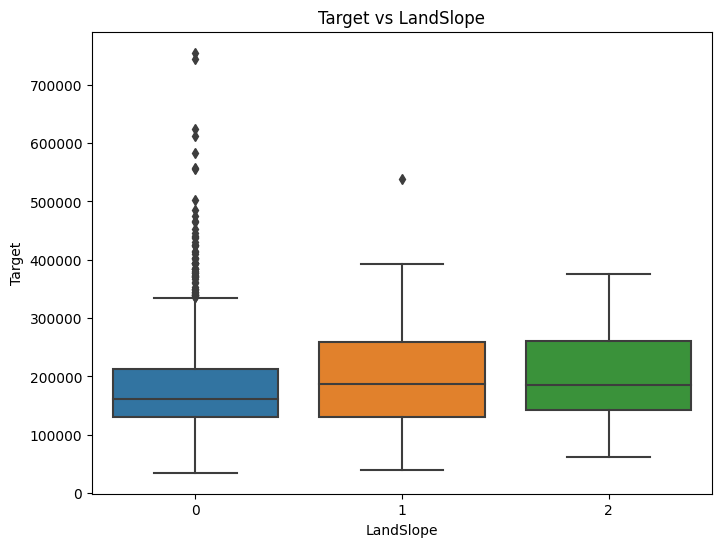

Checking ordinal relationship for column: Neighborhood
Neighborhood
0     194870.882353
1     137500.000000
2     104493.750000
3     124834.051724
4     212565.428571
5     197965.773333
6     210624.725490
7     128219.700000
8     192854.506329
9     100123.783784
10     98576.470588
11    156270.122449
12    145847.080000
13    142694.444444
14    189050.068493
15    335295.317073
16    316270.623377
17    128225.300885
18    142591.360000
19    136793.135135
20    186555.796610
21    225379.837209
22    310499.000000
23    242247.447368
24    238772.727273
Name: SalePrice, dtype: float64


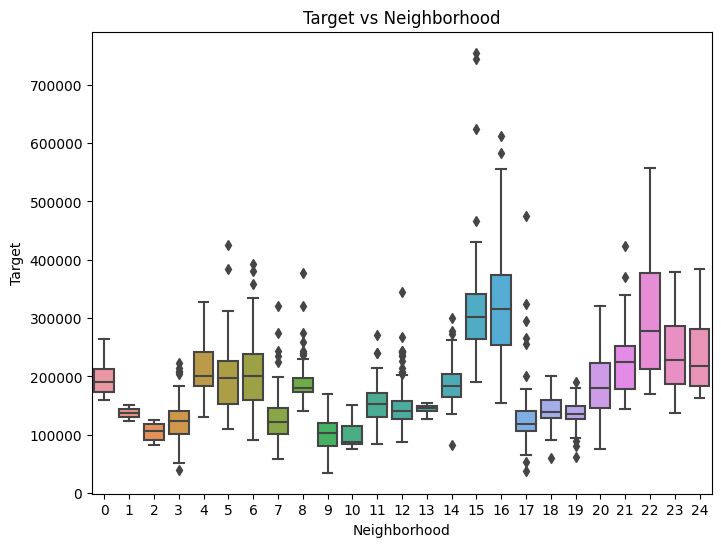

Checking ordinal relationship for column: Condition1
Condition1
0    135091.666667
1    142475.481481
2    184495.492063
3    225875.000000
4    215184.210526
5    138400.000000
6    184396.615385
7    190750.000000
8    212400.000000
Name: SalePrice, dtype: float64


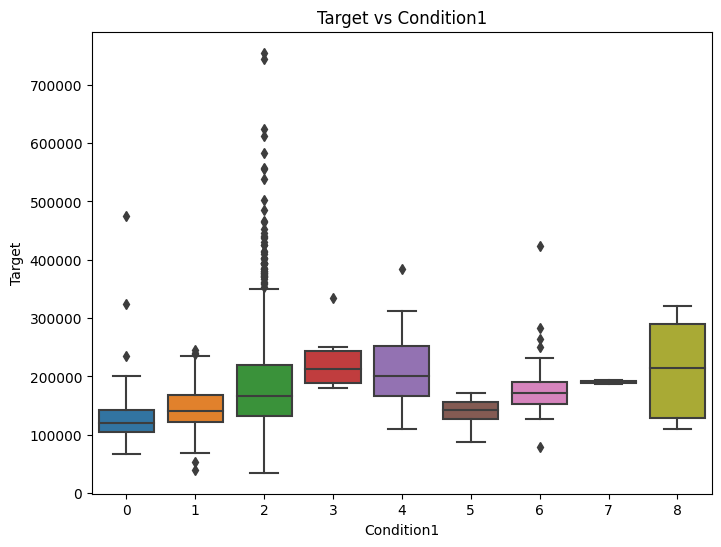

Checking ordinal relationship for column: Condition2
Condition2
0    106500.000000
1    121166.666667
2    181169.405536
3    325000.000000
4    284875.000000
5    190000.000000
6    136905.000000
7     96750.000000
Name: SalePrice, dtype: float64


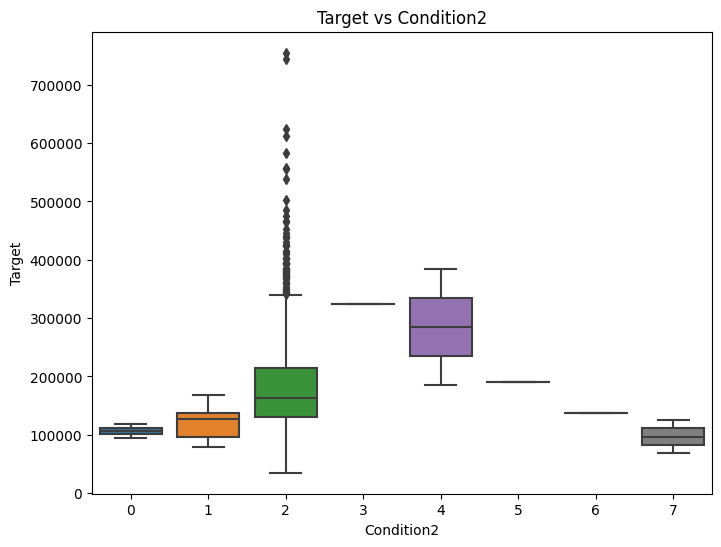

Checking ordinal relationship for column: BldgType
BldgType
0    185763.807377
1    128432.258065
2    133541.076923
3    135911.627907
4    181959.342105
Name: SalePrice, dtype: float64


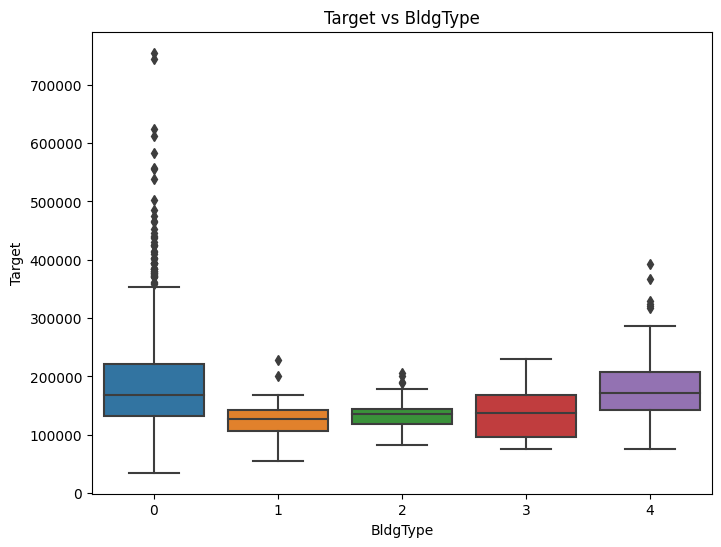

Checking ordinal relationship for column: HouseStyle
HouseStyle
0    143116.740260
1    110150.000000
2    175985.477961
3    220000.000000
4    157354.545455
5    210051.764045
6    135074.486486
7    166703.384615
Name: SalePrice, dtype: float64


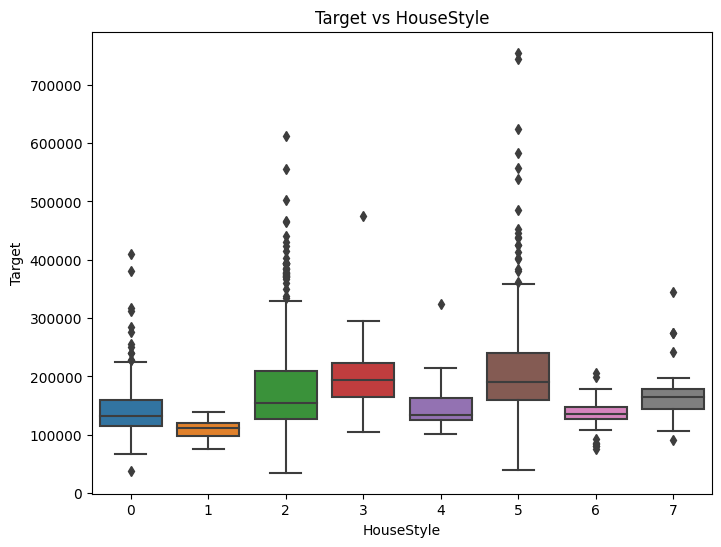

Checking ordinal relationship for column: RoofStyle
RoofStyle
0    194690.000000
1    171483.956179
2    148909.090909
3    218876.933566
4    180568.428571
5    225000.000000
Name: SalePrice, dtype: float64


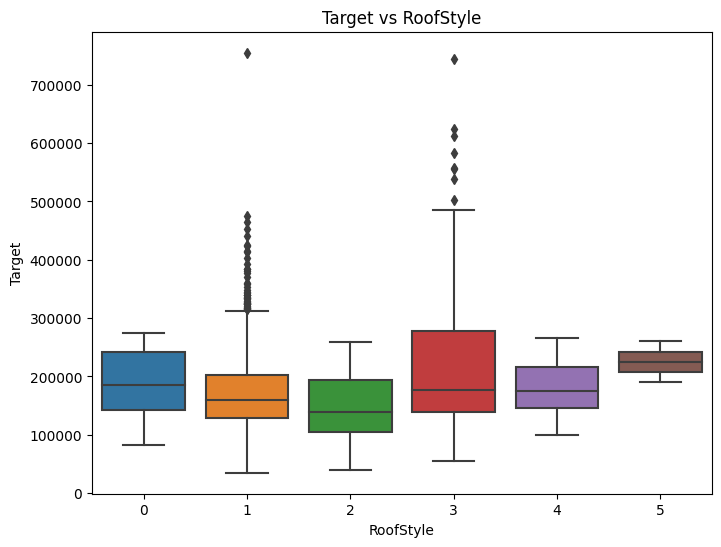

Checking ordinal relationship for column: RoofMatl
RoofMatl
0    160000.000000
1    179803.679219
2    241500.000000
3    180000.000000
4    137000.000000
5    185406.363636
6    241400.000000
7    390250.000000
Name: SalePrice, dtype: float64


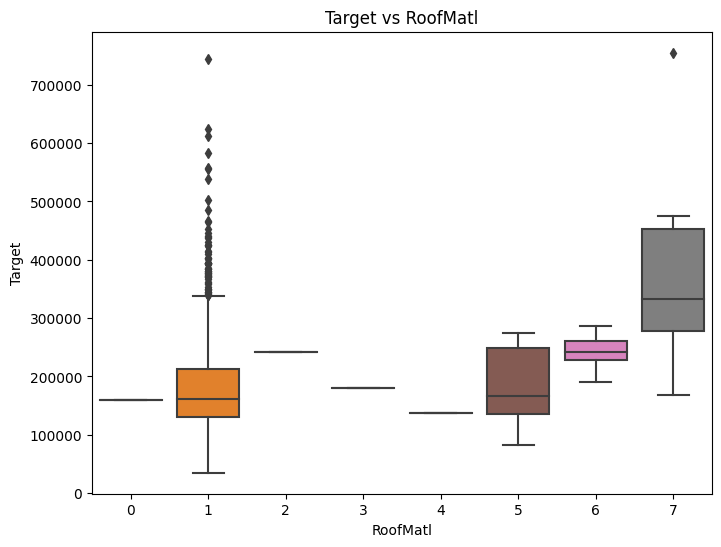

Checking ordinal relationship for column: Exterior1st
Exterior1st
0     107385.550000
1     100000.000000
2      71000.000000
3     194573.000000
4     105000.000000
5     231690.655738
6     163077.450450
7     262000.000000
8     149422.177273
9     175942.379630
10    258500.000000
11    162990.000000
12    213732.900971
13    149841.645631
14    150655.076923
Name: SalePrice, dtype: float64


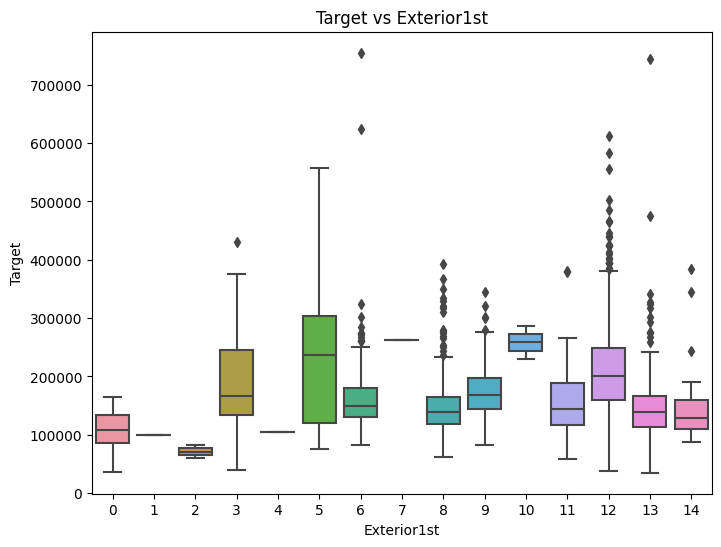

Checking ordinal relationship for column: Exterior2nd
Exterior2nd
0     114060.550000
1     138000.000000
2     126714.285714
3     195818.000000
4     105000.000000
5     230093.833333
6     167661.565217
7     252070.000000
8     149803.172897
9     319000.000000
10    168112.387324
11    158224.800000
12    155905.153846
13    214432.460317
14    148386.065990
15    161328.947368
Name: SalePrice, dtype: float64


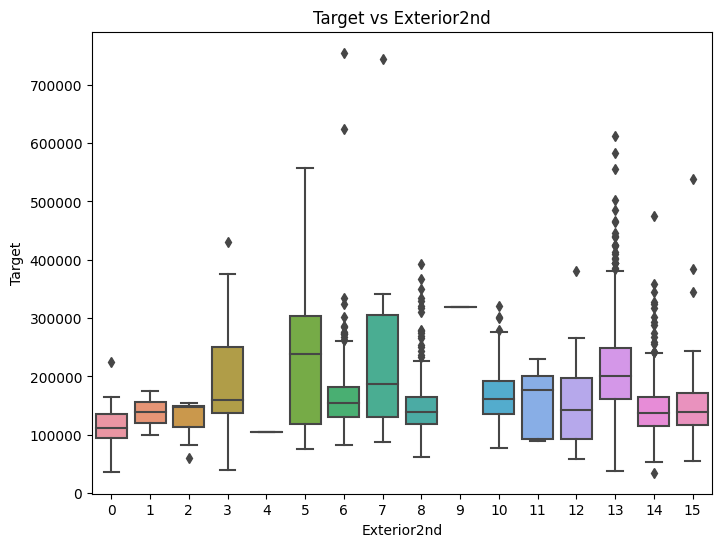

Checking ordinal relationship for column: ExterQual
ExterQual
0    367360.961538
1     87985.214286
2    231633.510246
3    144341.313466
Name: SalePrice, dtype: float64


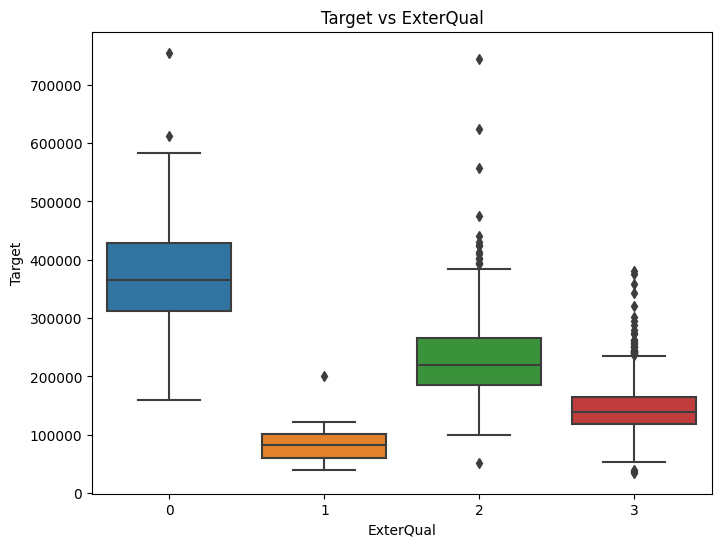

Checking ordinal relationship for column: ExterCond
ExterCond
0    201333.333333
1    102595.142857
2    168897.568493
3     76500.000000
4    184034.896256
Name: SalePrice, dtype: float64


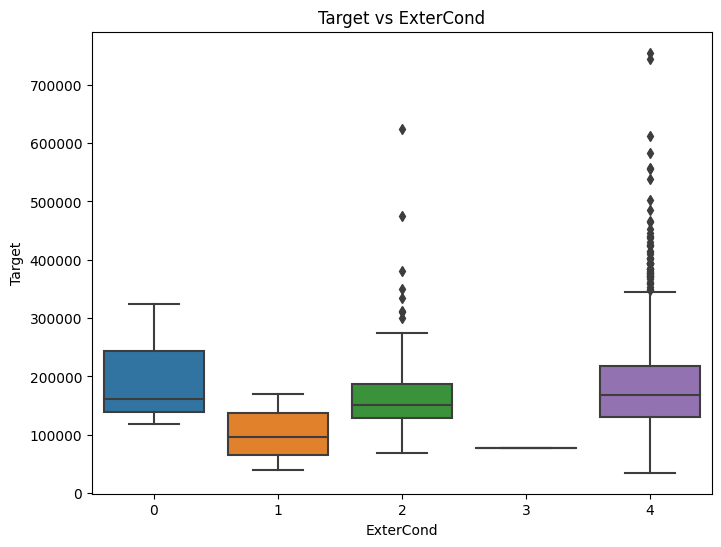

Checking ordinal relationship for column: Foundation
Foundation
0    132291.075342
1    149805.714511
2    225230.442040
3    107365.625000
4    165959.166667
5    185666.666667
Name: SalePrice, dtype: float64


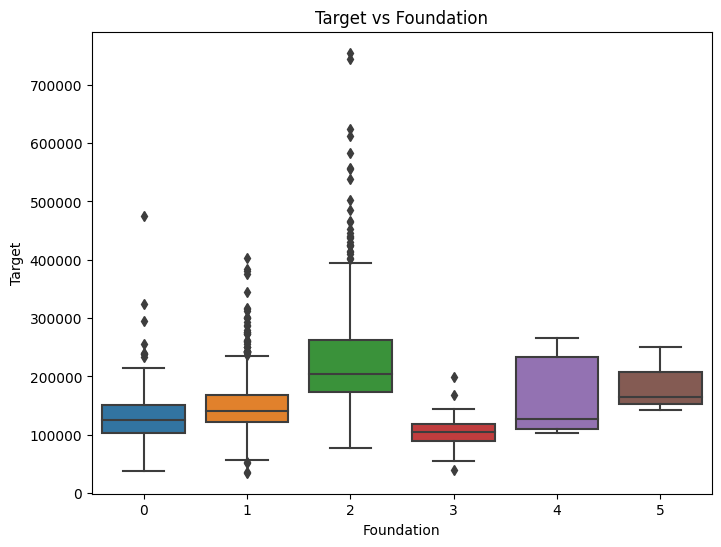

Checking ordinal relationship for column: BsmtQual
BsmtQual
0    327041.041322
1    115692.028571
2    202688.478964
3    138866.295918
Name: SalePrice, dtype: float64


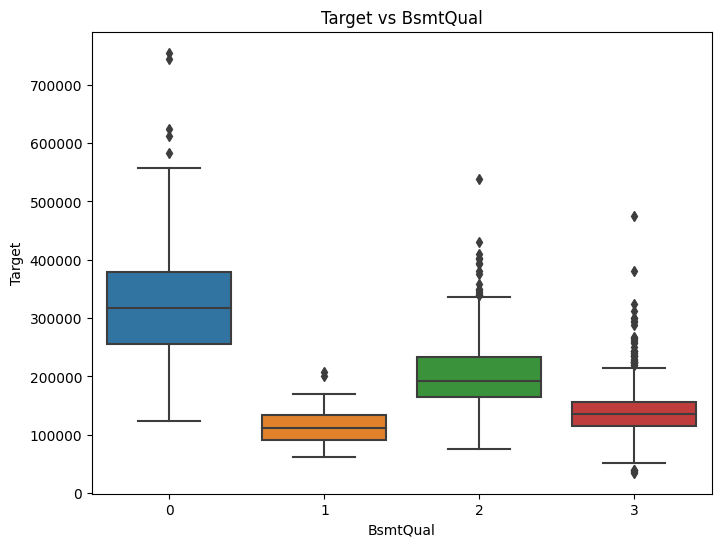

Checking ordinal relationship for column: BsmtCond
BsmtCond
0    121809.533333
1    213599.907692
2     64000.000000
3    181492.227745
Name: SalePrice, dtype: float64


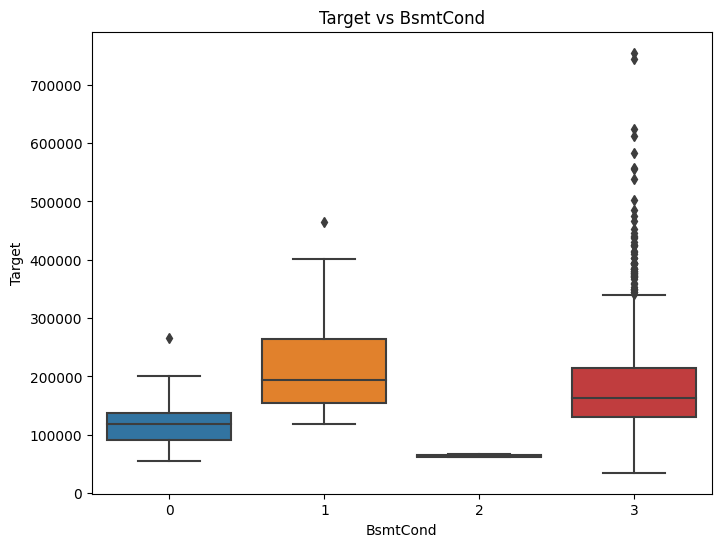

Checking ordinal relationship for column: BsmtExposure
BsmtExposure
0    206643.420814
1    257689.805970
2    192789.657895
3    163439.248234
Name: SalePrice, dtype: float64


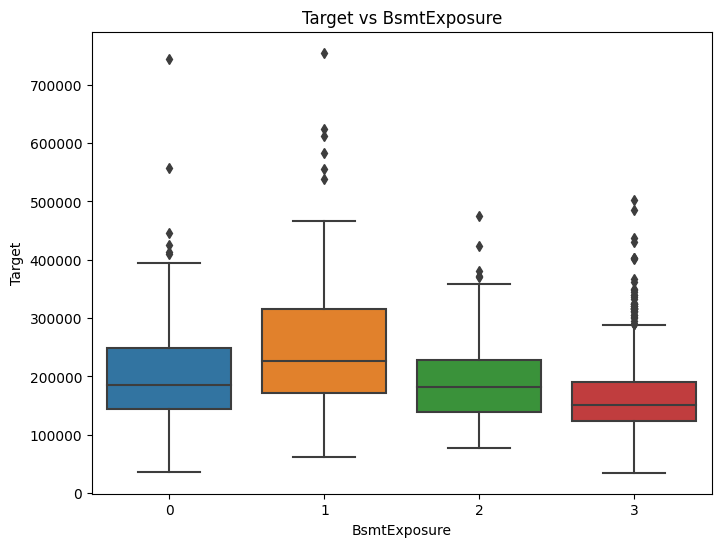

Checking ordinal relationship for column: BsmtFinType1
BsmtFinType1
0    161573.068182
1    149493.655405
2    235413.720096
3    151852.702703
4    146889.248120
5    165519.282655
Name: SalePrice, dtype: float64


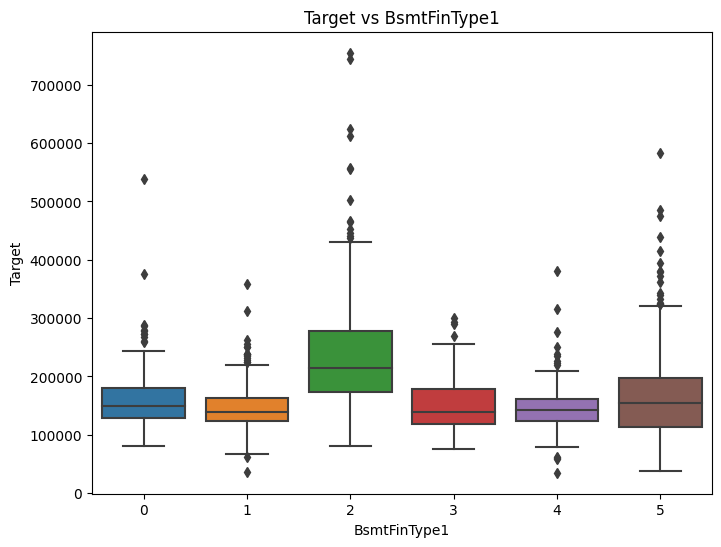

Checking ordinal relationship for column: BsmtFinType2
BsmtFinType2
0    209942.105263
1    151101.000000
2    180982.142857
3    164364.130435
4    164917.129630
5    182511.350850
Name: SalePrice, dtype: float64


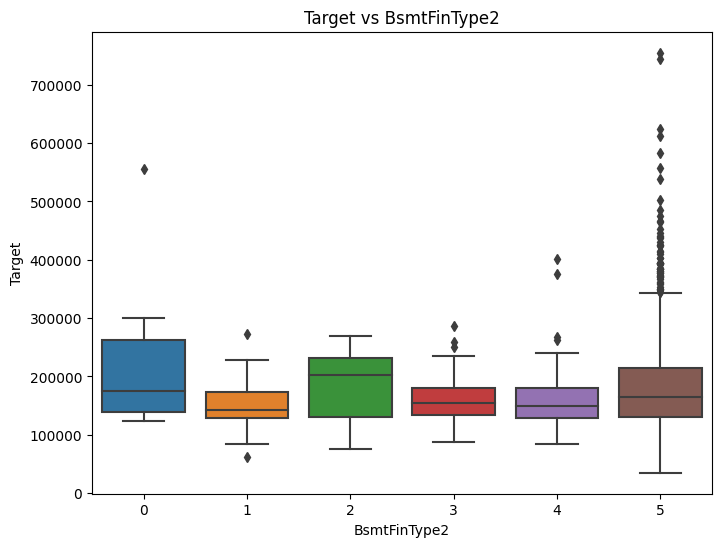

Checking ordinal relationship for column: Heating
Heating
0     72500.000000
1    182021.195378
2    166632.166667
3     75271.428571
4    125750.000000
5     92100.000000
Name: SalePrice, dtype: float64


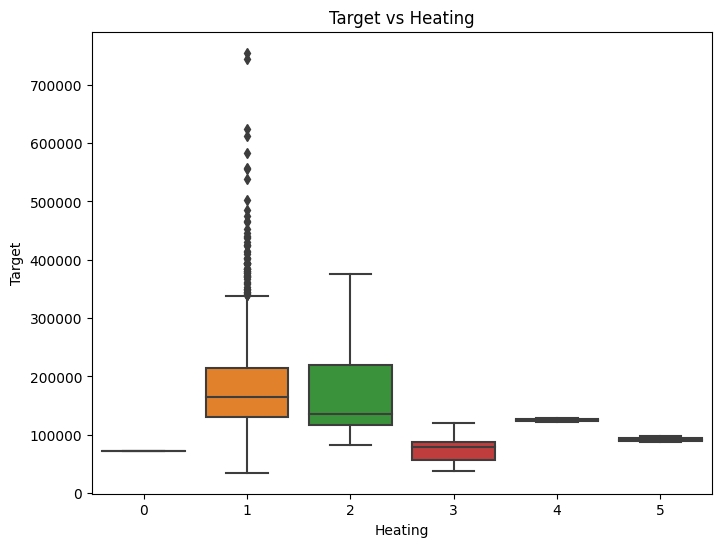

Checking ordinal relationship for column: HeatingQC
HeatingQC
0    214914.429150
1    123919.489796
2    156858.871369
3     87000.000000
4    142362.876168
Name: SalePrice, dtype: float64


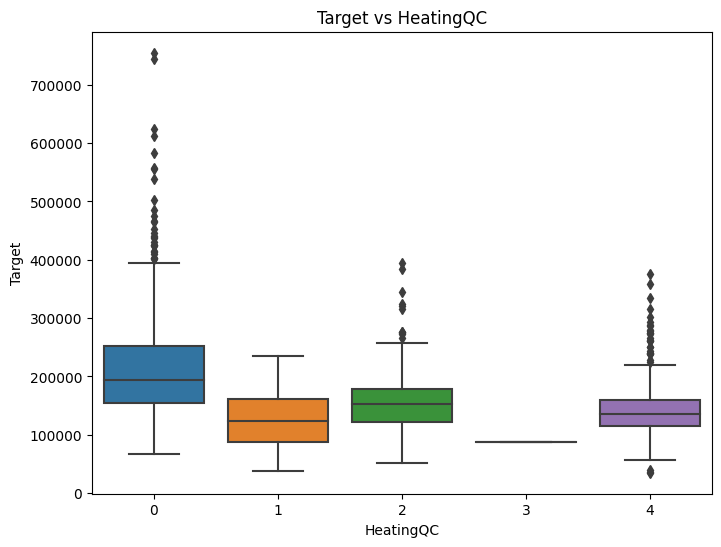

Checking ordinal relationship for column: CentralAir
CentralAir
0    105264.073684
1    186186.709890
Name: SalePrice, dtype: float64


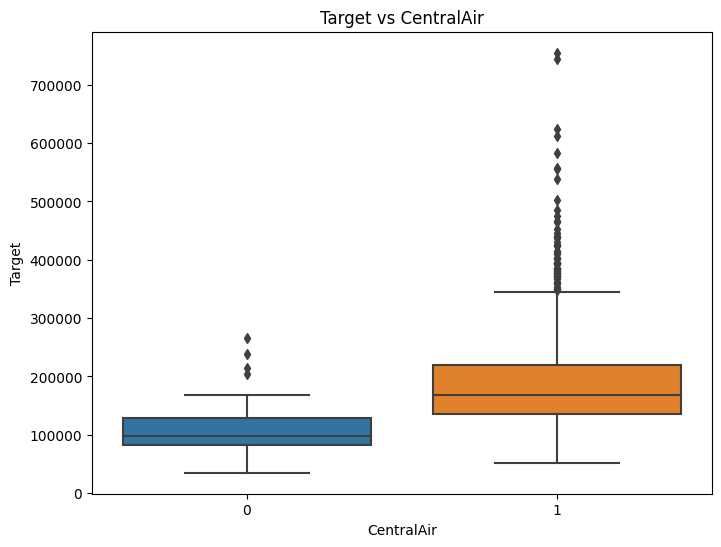

Checking ordinal relationship for column: Electrical
Electrical
0    122196.893617
1    107675.444444
2     97333.333333
3     67000.000000
4    186810.637453
Name: SalePrice, dtype: float64


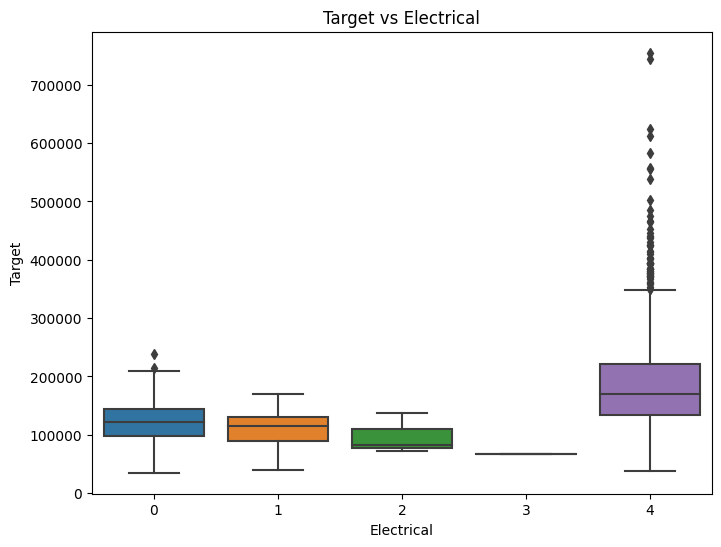

Checking ordinal relationship for column: KitchenQual
KitchenQual
0    328554.670000
1    105565.205128
2    212116.023891
3    139962.511565
Name: SalePrice, dtype: float64


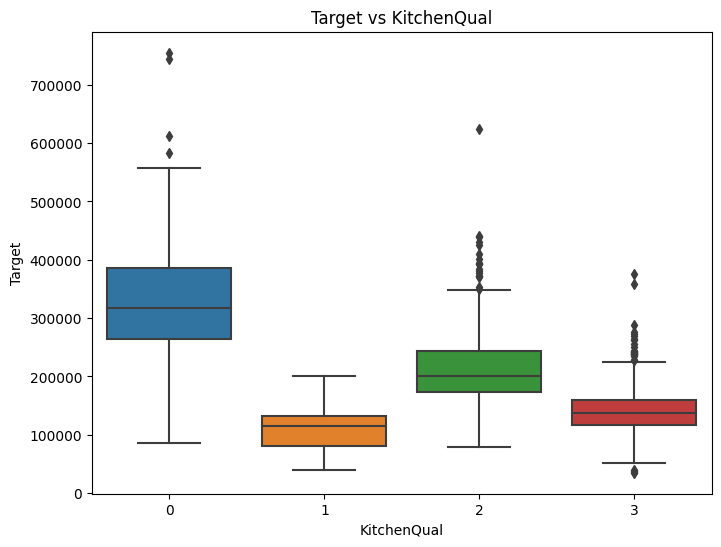

Checking ordinal relationship for column: Functional
Functional
0    153948.142857
1     85800.000000
2    146385.483871
3    144240.647059
4    168393.333333
5    129000.000000
6    183429.147059
Name: SalePrice, dtype: float64


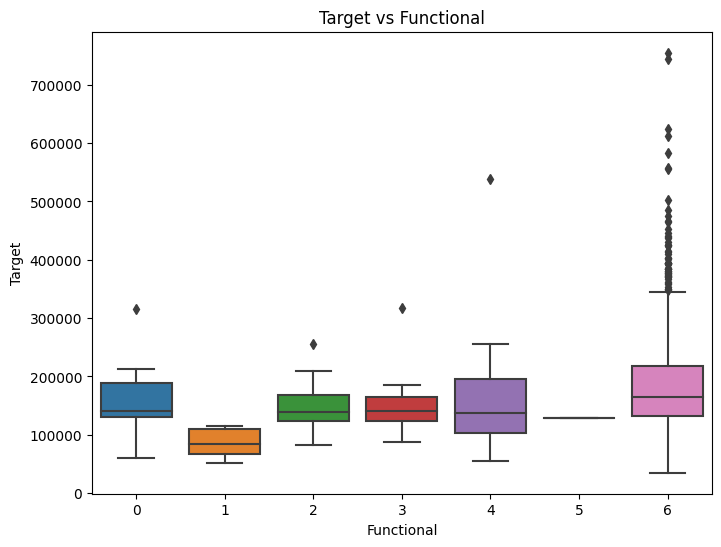

Checking ordinal relationship for column: GarageType
GarageType
0    151283.333333
1    194411.473186
2    160570.684211
3    254751.738636
4    109962.111111
5    134091.162791
Name: SalePrice, dtype: float64


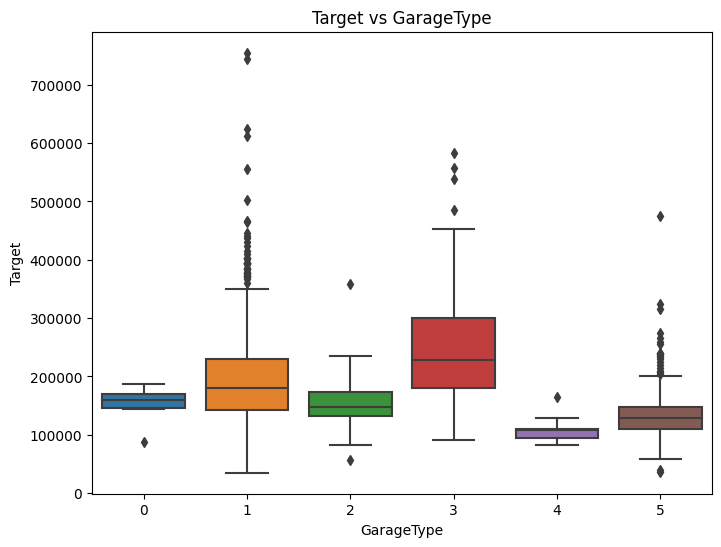

Checking ordinal relationship for column: GarageFinish
GarageFinish
0    240052.690341
1    202068.869668
2    137570.460641
Name: SalePrice, dtype: float64


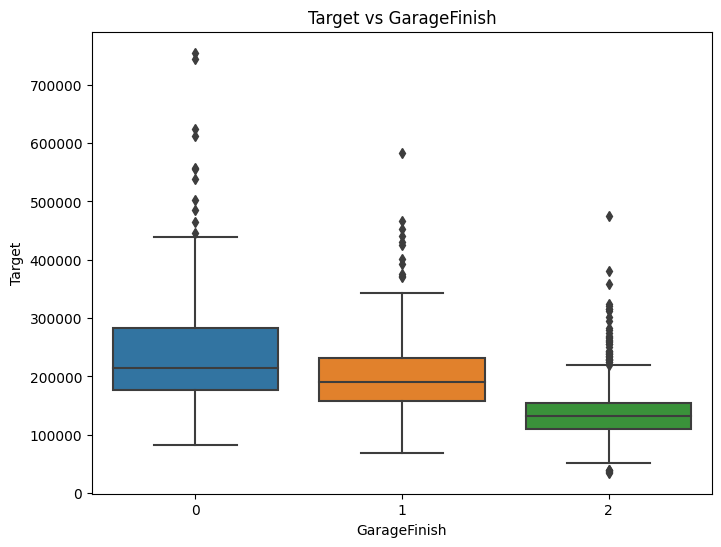

Checking ordinal relationship for column: GarageQual
GarageQual
0    241000.000000
1    123573.354167
2    215860.714286
3    100166.666667
4    182591.864224
Name: SalePrice, dtype: float64


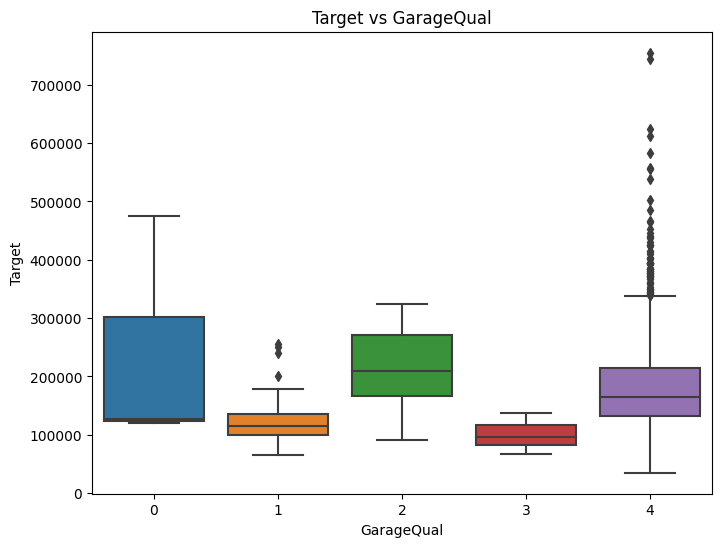

Checking ordinal relationship for column: GarageCond
GarageCond
0    124000.000000
1    114654.028571
2    179930.000000
3    108500.000000
4    183017.189055
Name: SalePrice, dtype: float64


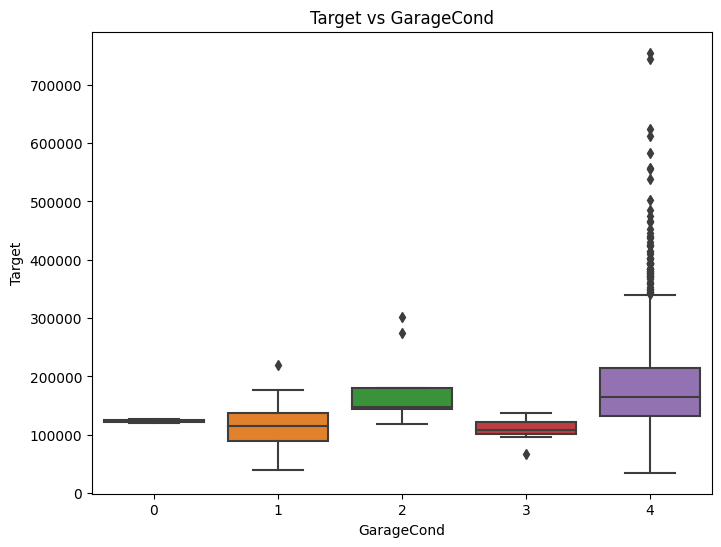

Checking ordinal relationship for column: PavedDrive
PavedDrive
0    115039.122222
1    132330.000000
2    186433.973881
Name: SalePrice, dtype: float64


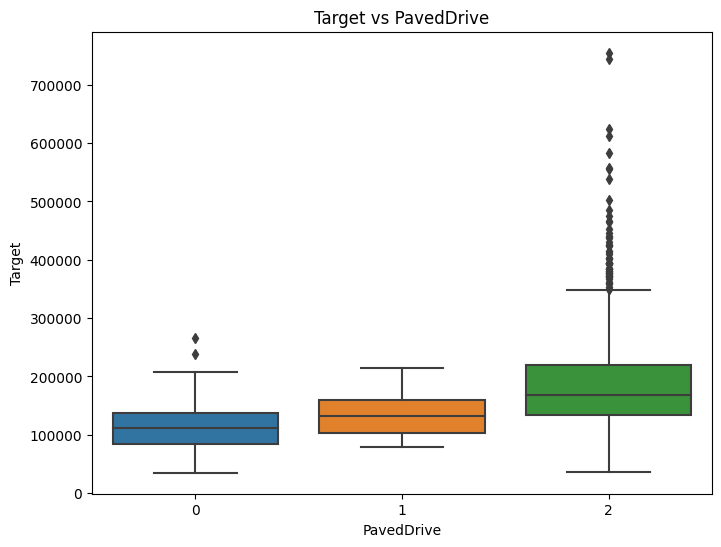

Checking ordinal relationship for column: SaleType
SaleType
0    143973.255814
1    210600.000000
2    269600.000000
3    138780.888889
4    200390.000000
5    143700.000000
6    274945.418033
7    119850.000000
8    173401.836622
Name: SalePrice, dtype: float64


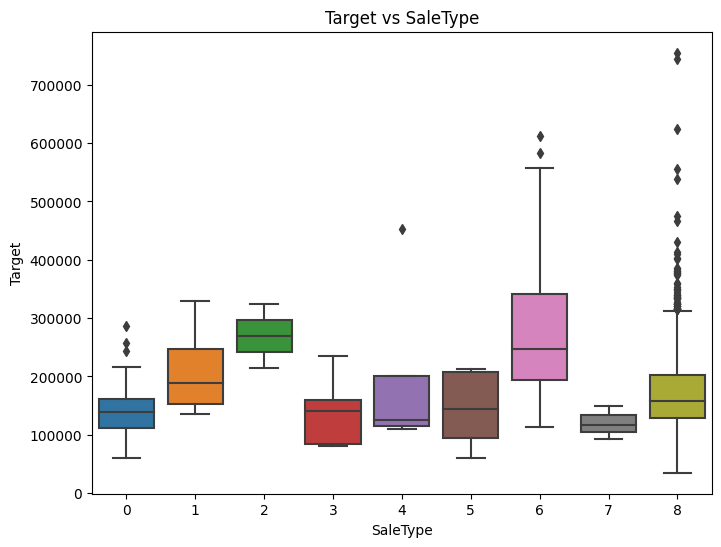

Checking ordinal relationship for column: SaleCondition
SaleCondition
0    146526.623762
1    104125.000000
2    167377.416667
3    149600.000000
4    175202.219533
5    272291.752000
Name: SalePrice, dtype: float64


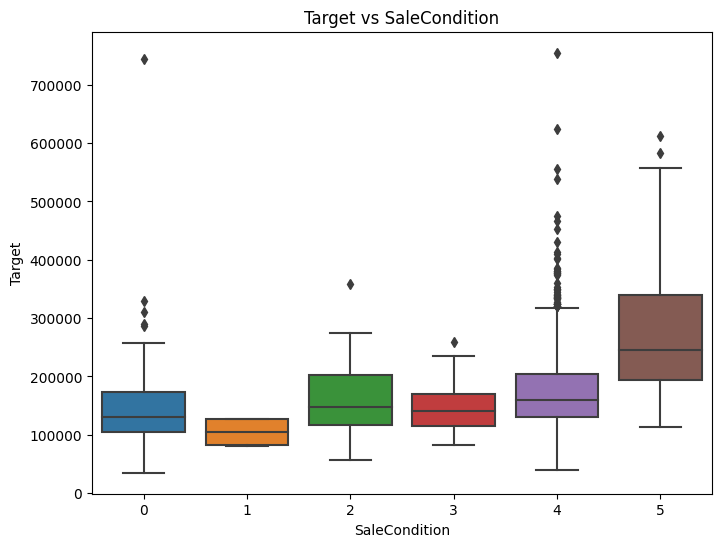

In [19]:
for column in categorical_cols:
    print(f"Checking ordinal relationship for column: {column}")

    grouped = X_train_with_target.groupby(column)[target_variable].mean()
    print(grouped)

    plt.figure(figsize=(8,6))
    sns.boxplot(x=X_train_with_target[column], y=X_train_with_target[target_variable])
    plt.title(f"Target vs {column}")
    plt.xlabel(f"{column}")
    plt.ylabel('Target')
    plt.show()

## Standrization

In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

스케일링 과정은 인코딩 과정과 다르게 열마다 다르게 적용하는 것이 아닌 모두 통합적으로 시행해도 됨

In [21]:
# 데이터의 열 이름을 숫자로 초기화
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,0.073375,-0.045532,-0.207142,0.064238,0.750731,0.314667,-0.02618,0.604670,-0.225716,-1.206215,...,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,0.313867,0.208502,-1.043259,-0.459303,0.224756
1,-0.872563,-0.045532,-0.091886,0.064238,0.750731,0.314667,-0.02618,-0.628316,-0.225716,1.954302,...,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,0.313867,0.208502,-0.183465,0.466465,0.314624
2,0.073375,-0.045532,0.073480,0.064238,-1.378933,0.314667,-0.02618,0.604670,-0.225716,-1.206215,...,-0.270208,-0.068692,-0.087688,0.990891,0.138777,0.313867,0.208502,-0.977121,-0.313369,-1.334900
3,0.309859,-0.045532,-0.096897,0.064238,-1.378933,0.314667,-0.02618,-1.861302,-0.225716,-1.039872,...,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,0.313867,-3.426284,1.800676,-0.687324,-0.486525
4,0.073375,-0.045532,0.375148,0.064238,-1.378933,0.314667,-0.02618,-0.628316,-0.225716,0.457215,...,-0.270208,-0.068692,-0.087688,2.100892,0.138777,0.313867,0.208502,-0.944052,0.199680,-0.465531


In [22]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,-0.872563,-1.628309,0.110763,0.064238,0.750731,0.314667,-0.02618,0.604670,-0.225716,-0.041814,...,1.882709,-0.068692,-0.087688,-0.119110,1.64521,0.313867,0.208502,0.411777,-0.400017,1.291404
1,-0.872563,-0.045532,0.375850,0.064238,-1.378933,0.314667,-0.02618,-1.861302,-0.225716,-0.041814,...,-0.270208,-0.068692,25.116309,-0.119110,1.64521,0.313867,0.208502,0.510984,0.619239,0.031186
2,0.073375,-0.045532,0.332053,0.064238,-1.378933,0.314667,-0.02618,0.604670,-0.225716,-0.707186,...,-0.270208,-0.068692,-0.087688,-1.229111,1.64521,0.313867,0.208502,-0.778707,-0.295127,-0.952018
3,0.073375,-0.045532,-0.054002,0.064238,-1.378933,0.314667,-0.02618,0.604670,-0.225716,-0.707186,...,-0.270208,-0.068692,-0.087688,-0.119110,1.64521,0.313867,0.208502,-0.811776,-0.299687,-0.146885
4,1.492282,-0.045532,-0.552407,0.064238,-1.378933,-2.512494,-0.02618,0.604670,-0.225716,1.621616,...,2.313293,-0.068692,-0.087688,-1.969111,1.64521,0.313867,0.208502,-0.613362,0.507509,-0.688300


## Feature Selection

In [23]:
FeatureSelection = SelectKBest(score_func=f_classif, k=56)
X_train_selected = FeatureSelection.fit_transform(X_train, y_train)
X_test_selected = FeatureSelection.transform(X_test)

selected_features = FeatureSelection.get_support(indices=True)
selected_feature_names = pd.DataFrame(X_train).columns[selected_features]

SelectKBest: 데이터의 feature 중 가장 중요한 k개를 선택하는 메소드

In [24]:
X_train_selected = pd.DataFrame(X_train_selected)
X_train_selected

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,-0.045532,-0.207142,0.064238,0.750731,0.314667,-0.225716,-1.206215,-0.03174,-0.411691,1.026689,...,0.289745,-0.752176,0.216503,-0.270208,-0.087688,0.138777,0.208502,-1.043259,-0.459303,0.224756
1,-0.045532,-0.091886,0.064238,0.750731,0.314667,-0.225716,1.954302,-0.03174,-0.411691,-0.543457,...,0.289745,1.626195,-0.704483,-0.270208,-0.087688,-0.614439,0.208502,-0.183465,0.466465,0.314624
2,-0.045532,0.073480,0.064238,-1.378933,0.314667,-0.225716,-1.206215,-0.03174,-0.411691,1.026689,...,0.289745,-0.752176,-0.070361,-0.270208,-0.087688,0.138777,0.208502,-0.977121,-0.313369,-1.334900
3,-0.045532,-0.096897,0.064238,-1.378933,0.314667,-0.225716,-1.039872,-0.03174,-0.411691,1.026689,...,0.289745,-0.752176,-0.176048,-0.270208,-0.087688,-1.367655,-3.426284,1.800676,-0.687324,-0.486525
4,-0.045532,0.375148,0.064238,-1.378933,0.314667,-0.225716,0.457215,-0.03174,-0.411691,1.026689,...,0.289745,0.780197,0.563760,-0.270208,-0.087688,0.138777,0.208502,-0.944052,0.199680,-0.465531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.045532,-0.260560,0.064238,0.750731,0.314667,-0.225716,-0.707186,-0.03174,-0.411691,1.026689,...,0.289745,-0.752176,-0.100558,-0.270208,-0.087688,-0.614439,0.208502,-0.944052,-0.238122,-0.281622
1456,-0.045532,0.266407,0.064238,0.750731,0.314667,-0.225716,0.290872,-0.03174,-0.411691,-0.543457,...,0.289745,2.033231,-0.704483,-0.270208,-0.087688,1.645210,0.208502,-0.150396,1.104925,-1.314459
1457,-0.045532,-0.147810,0.064238,0.750731,0.314667,-0.225716,-1.039872,-0.03174,-0.411691,1.026689,...,0.289745,-0.752176,0.201405,-0.270208,4.953112,1.645210,0.208502,1.073157,0.215641,-0.759367
1458,-0.045532,-0.080160,0.064238,0.750731,0.314667,-0.225716,-0.041814,-0.03174,-0.411691,-0.543457,...,0.289745,2.168910,-0.704483,-0.270208,-0.087688,1.645210,0.208502,0.775536,0.046905,0.177285


In [25]:
X_test_selected=pd.DataFrame(X_test_selected)
X_test_selected

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,-1.628309,0.110763,0.064238,0.750731,0.314667,-0.225716,-0.041814,-0.03174,-0.411691,-0.543457,...,0.289745,0.365179,-0.704483,1.882709,-0.087688,1.645210,0.208502,0.411777,-0.400017,1.291404
1,-0.045532,0.375850,0.064238,-1.378933,0.314667,-0.225716,-0.041814,-0.03174,-0.411691,-0.543457,...,0.289745,2.384400,-0.160950,-0.270208,25.116309,1.645210,0.208502,0.510984,0.619239,0.031186
2,-0.045532,0.332053,0.064238,-1.378933,0.314667,-0.225716,-0.707186,-0.03174,-0.411691,1.026689,...,0.289745,0.939819,-0.191147,-0.270208,-0.087688,1.645210,0.208502,-0.778707,-0.295127,-0.952018
3,-0.045532,-0.054002,0.064238,-1.378933,0.314667,-0.225716,-0.707186,-0.03174,-0.411691,1.026689,...,0.289745,2.121024,-0.160950,-0.270208,-0.087688,1.645210,0.208502,-0.811776,-0.299687,-0.146885
4,-0.045532,-0.552407,0.064238,-1.378933,-2.512494,-0.225716,1.621616,-0.03174,2.927579,-0.543457,...,0.289745,-0.752176,0.533564,2.313293,-0.087688,1.645210,0.208502,-0.613362,0.507509,-0.688300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1.537245,-0.859988,0.064238,0.750731,0.314667,-0.225716,-0.374500,-0.03174,2.092762,1.026689,...,0.289745,-0.752176,-0.704483,-0.270208,-0.087688,-1.367655,0.208502,-0.018120,-1.166169,0.106965
1455,1.537245,-0.864197,0.064238,0.750731,0.314667,-0.225716,-0.374500,-0.03174,2.927579,1.026689,...,0.289745,-0.752176,-0.342128,-0.270208,-0.087688,-1.367655,-3.426284,-0.018120,-1.166169,1.189881
1456,-0.045532,0.950423,0.064238,0.750731,0.314667,-0.225716,-0.208157,-0.03174,-0.411691,-0.543457,...,0.289745,3.030870,-0.704483,-0.270208,-0.087688,-1.367655,-3.426284,0.312570,0.379817,1.455301
1457,-0.045532,-0.007600,0.064238,0.750731,0.314667,-0.225716,-0.208157,-0.03174,-0.411691,1.550071,...,0.289745,-0.113687,-0.221343,-0.270208,1.323736,-1.367655,0.208502,-0.745638,-0.331610,2.007091


## Build the model

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X_train_selected, y_train, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_val)

## Evaluation

In [27]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"RMSE: {rmse}, MAE: {mae}, R²: {r2}")

scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
print(f"Cross-validated RMSE: {rmse_scores.mean()} ±{rmse_scores.std()}")

RMSE: 27845.370265435657, MAE: 17571.484589041094, R²: 0.898913732705046
Cross-validated RMSE: 30333.095458544478 ±5169.22659274796


## Improve the model using XGBoost

In [28]:
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.5,
    min_child_weight=3,
    gamma=0,
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)

rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
r2_xgb = r2_score(y_val, y_pred_xgb)
print(f"XGBoost RMSE: {rmse_xgb}, R²: {r2_xgb}")

XGBoost RMSE: 24500.111248924222, R²: 0.9217431651541467


In [29]:
y_test_pred = rf_model.predict(X_test_selected)

test_data_original = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
submission = pd.DataFrame({'Id': test_data_original['Id'], 'SalePrice': y_test_pred})
submission.to_csv('submission.csv', index=False)